# Spam Filter

This is an implementation of a Spam Filter using a Naïve Bayes classifier.

In [1]:
import os
import re
import csv
import random
import matplotlib.pyplot as plt

In [2]:
master_vocabulary = []
ham_line_paths = []
spam_line_paths = []
with open('./labels', 'r') as file:
    for line in file.readlines():
        if re.match(r'ham', line):
            ham_line_paths.append(line)
        elif re.match(r'spam', line):
            spam_line_paths.append(line)

In [3]:
def write_word_vectors(filename, line_paths, classification, master_vocabulary):
    full_vocabulary = {}
    full_file_vocabs = []
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        for line_path in line_paths:
            path = os.path.join(os.getcwd(), re.sub(r'{} \.\.\/'.format(classification), '', line_path)).strip()
            with open(path, 'rb') as file:
                file_vocab = {'[[file_path]]': line_path.strip()}

                for line in file.readlines():
                    try:
                        split_words = re.findall(r'[A-Za-z]+', line.decode('utf-8'))
                    except UnicodeDecodeError:
                        continue
                    for w in split_words:
                        if full_vocabulary.get(w.lower(), None):
                            full_vocabulary[w.lower()] += 1
                        else:
                            full_vocabulary[w.lower()] = 1

                        if file_vocab.get(w.lower(), None):
                            file_vocab[w.lower()] += 1
                        else:
                            file_vocab[w.lower()] = 1
                        master_vocabulary.append(w)
                full_file_vocabs.append(file_vocab)
        print('vocabulary sorted!')
    
    return full_vocabulary, full_file_vocabs, list(set(master_vocabulary))

In [4]:
ham_vocabulary, ham_file_vocabs, master_vocabulary = write_word_vectors('hamvectors.csv', ham_line_paths, 'ham', master_vocabulary)
print(len(ham_vocabulary.values()))
ham_full = [*ham_file_vocabs]

vocabulary sorted!
2130014


In [5]:
spam_vocabulary, spam_file_vocabs, master_vocabulary = write_word_vectors('spamvectors.csv', spam_line_paths, 'spam', master_vocabulary)
print(len(spam_vocabulary.values()))
spam_full = [*spam_file_vocabs]

vocabulary sorted!
260921


In [6]:
def take_split(dataset, training_percentage):
    dataset_length = len(dataset)
    sample_count = (dataset_length * (training_percentage / 100)) // 1
    training_sample = []

    while sample_count > 0:
        current_index = random.randint(0, len(dataset) - 1)
        training_sample.append(dataset[current_index])
        del dataset[current_index]
        sample_count -= 1

    return training_sample, dataset

In [7]:
# Split into 70% training and 30% test set
ham_training, ham_test = take_split(ham_full, 70)
print(len(ham_file_vocabs))
print(len(ham_training), len(ham_test))

spam_training, spam_test = take_split(spam_full, 70)
print(len(spam_file_vocabs))
print(len(spam_training), len(spam_test))

12910
9037 3873
24912
17438 7474


In [8]:
print('prior probabilities for Spam and Ham: ')
print('ham class: ', len(ham_training), '/', len(ham_training) + len(spam_training))
print('spam class: ', len(spam_training),  ' / ', len(ham_training) + len(spam_training))

prior probabilities for Spam and Ham: 
ham class:  9037 / 26475
spam class:  17438  /  26475


In [9]:
# We only care about how many times this word occurred across different document Ds
rebuilt_ham_vocabulary_probabilities = {}
for item in ham_training:
    for word in item:
        if rebuilt_ham_vocabulary_probabilities.get(word, None):
            rebuilt_ham_vocabulary_probabilities[word] += 1
        else:
            rebuilt_ham_vocabulary_probabilities[word] = 1

for key in rebuilt_ham_vocabulary_probabilities.keys():
    rebuilt_ham_vocabulary_probabilities[key] = (rebuilt_ham_vocabulary_probabilities[key] + 1) / (len(ham_training) + len(master_vocabulary))
    
ham_vocabulary_size = len(rebuilt_ham_vocabulary_probabilities.keys())

rebuilt_spam_vocabulary_probabilities = {}
for item in spam_training:
    for word in item:
        if rebuilt_spam_vocabulary_probabilities.get(word, None):
            rebuilt_spam_vocabulary_probabilities[word] += 1
        else:
            rebuilt_spam_vocabulary_probabilities[word] = 1

for key in rebuilt_spam_vocabulary_probabilities:
    rebuilt_spam_vocabulary_probabilities[key] = (rebuilt_spam_vocabulary_probabilities[key] + 1) / (len(spam_training) + len(master_vocabulary))

spam_vocabulary_size = len(rebuilt_spam_vocabulary_probabilities.keys())

full_vocabulary_size = len(set(list(rebuilt_ham_vocabulary_probabilities.keys()) + list(rebuilt_spam_vocabulary_probabilities.keys())))

In [10]:

def apply_to_test(test_set, ham_training, spam_training, lamb):
    classified_as_ham = 0
    classified_as_spam = 0
    for item in test_set:
        ham_probability = len(ham_training) / (len(ham_training) + len(ham_test))
        spam_probability = len(spam_training) / (len(spam_training) + len(spam_test))

        ham_default = 1 / (len(ham_training) + lamb * len(ham_training))
        spam_default = 1 / (len(spam_training) + lamb * len(spam_training))
        for word in item.keys():
            ham_component = rebuilt_ham_vocabulary_probabilities.get(word)
            spam_component = rebuilt_spam_vocabulary_probabilities.get(word)
            ham_percent = ham_component if ham_component else ham_default
            spam_percent = spam_component if spam_component else spam_default

            if ham_probability * ham_percent == 0:
                break
            if spam_probability * spam_percent == 0:
                break
            ham_probability *= ham_percent
            spam_probability *= spam_percent

        if ham_probability > spam_probability:
            classified_as_ham += 1
        else:
            classified_as_spam += 1

    return classified_as_ham, classified_as_spam

In [11]:
classified_as_ham = 0
classified_as_spam = 0

classified_as_ham, classified_as_spam = apply_to_test(ham_test, ham_training, spam_training, 1)
print('Classified ham (TN): ', classified_as_ham, '/', len(ham_test))
tn_l1 = classified_as_ham
print('Classified spam (FP): ', classified_as_spam, '/', len(ham_test))
fp_l1 = classified_as_spam

classified_as_ham, classified_as_spam = apply_to_test(spam_test, ham_training, spam_training, 1)
print('Classified ham (FN): ', classified_as_ham, '/', len(spam_test))
fn_l1 = classified_as_ham
print('Classified spam (TP): ', classified_as_spam, '/', len(spam_test))
tp_l1 = classified_as_spam

Classified ham (TN):  1769 / 3873
Classified spam (FP):  2104 / 3873
Classified ham (FN):  168 / 7474
Classified spam (TP):  7306 / 7474


In [12]:
precision_l1 = tp_l1 / (tp_l1 + fp_l1)
recall_l1 = tp_l1 / (tp_l1 + fn_l1)
print('precision: ', precision_l1)
print('recall: ', recall_l1)

precision:  0.7764080765143464
recall:  0.9775220765319775


# Lambda Smoothing tests

We will now be applying different values of lambda into different runs of our classifier to measure differences in precision and recall.

## At λ = 1

In [13]:
classified_as_ham = 0
classified_as_spam = 0

classified_as_ham, classified_as_spam = apply_to_test(ham_test, ham_training, spam_training, lamb=1)
print('Classified ham (TN): ', classified_as_ham, '/', len(ham_test))
tn_l1 = classified_as_ham
print('Classified spam (FP): ', classified_as_spam, '/', len(ham_test))
fp_l1 = classified_as_spam

classified_as_ham, classified_as_spam = apply_to_test(spam_test, ham_training, spam_training, lamb=1)
print('Classified ham (FN): ', classified_as_ham, '/', len(spam_test))
fn_l1 = classified_as_ham
print('Classified spam (TP): ', classified_as_spam, '/', len(spam_test))
tp_l1 = classified_as_spam

precision_l1 = tp_l1 / (tp_l1 + fp_l1)
recall_l1 = tp_l1 / (tp_l1 + fn_l1)
print('precision: ', precision_l1)
print('recall: ', recall_l1)

Classified ham (TN):  1769 / 3873
Classified spam (FP):  2104 / 3873
Classified ham (FN):  168 / 7474
Classified spam (TP):  7306 / 7474
precision:  0.7764080765143464
recall:  0.9775220765319775


## At λ = 2

In [14]:
classified_as_ham = 0
classified_as_spam = 0

classified_as_ham, classified_as_spam = apply_to_test(ham_test, ham_training, spam_training, lamb=2)
print('Classified ham (TN): ', classified_as_ham, '/', len(ham_test))
tn_l2 = classified_as_ham
print('Classified spam (FP): ', classified_as_spam, '/', len(ham_test))
fp_l2 = classified_as_spam

classified_as_ham, classified_as_spam = apply_to_test(spam_test, ham_training, spam_training, lamb=2)
print('Classified ham (FN): ', classified_as_ham, '/', len(spam_test))
fn_l2 = classified_as_ham
print('Classified spam (TP): ', classified_as_spam, '/', len(spam_test))
tp_l2 = classified_as_spam

precision_l2 = tp_l2 / (tp_l2 + fp_l2)
recall_l2 = tp_l2 / (tp_l2 + fn_l2)
print('precision: ', precision_l2)
print('recall: ', recall_l2)

Classified ham (TN):  1917 / 3873
Classified spam (FP):  1956 / 3873
Classified ham (FN):  108 / 7474
Classified spam (TP):  7366 / 7474
precision:  0.790173782450118
recall:  0.9855499063419856


## At λ = 0.5

In [15]:
classified_as_ham = 0
classified_as_spam = 0

classified_as_ham, classified_as_spam = apply_to_test(ham_test, ham_training, spam_training, lamb=0.5)
print('Classified ham (TN): ', classified_as_ham, '/', len(ham_test))
tn_l3 = classified_as_ham
print('Classified spam (FP): ', classified_as_spam, '/', len(ham_test))
fp_l3 = classified_as_spam

classified_as_ham, classified_as_spam = apply_to_test(spam_test, ham_training, spam_training, lamb=0.5)
print('Classified ham (FN): ', classified_as_ham, '/', len(spam_test))
fn_l3 = classified_as_ham
print('Classified spam (TP): ', classified_as_spam, '/', len(spam_test))
tp_l3 = classified_as_spam

precision_l3 =  tp_l3 / (tp_l3 + fp_l3)
recall_l3 = tp_l3 / (tp_l3 + fn_l3)
print('precision: ', precision_l3)
print('recall: ', recall_l3)

Classified ham (TN):  1642 / 3873
Classified spam (FP):  2231 / 3873
Classified ham (FN):  223 / 7474
Classified spam (TP):  7251 / 7474
precision:  0.7647120860577937
recall:  0.9701632325394701


## At λ = 0.1

In [16]:
classified_as_ham = 0
classified_as_spam = 0

classified_as_ham, classified_as_spam = apply_to_test(ham_test, ham_training, spam_training, lamb=0.1)
print('Classified ham (TN): ', classified_as_ham, '/', len(ham_test))
tn_l4 = classified_as_ham
print('Classified spam (FP): ', classified_as_spam, '/', len(ham_test))
fp_l4 = classified_as_spam

classified_as_ham, classified_as_spam = apply_to_test(spam_test, ham_training, spam_training, lamb=0.1)
print('Classified ham (FN): ', classified_as_ham, '/', len(spam_test))
fn_l4 = classified_as_ham
print('Classified spam (TP): ', classified_as_spam, '/', len(spam_test))
tp_l4 = classified_as_spam

precision_l4 = tp_l4 / (tp_l4 + fp_l4)
recall_l4 = tp_l4 / (tp_l4 + fn_l4)
print('precision: ', precision_l4)
print('recall: ', recall_l4)

Classified ham (TN):  1504 / 3873
Classified spam (FP):  2369 / 3873
Classified ham (FN):  286 / 7474
Classified spam (TP):  7188 / 7474
precision:  0.7521188657528514
recall:  0.9617340112389617


## At λ = 0.005

In [17]:
classified_as_ham = 0
classified_as_spam = 0

classified_as_ham, classified_as_spam = apply_to_test(ham_test, ham_training, spam_training, lamb=0.005)
print('Classified ham (TN): ', classified_as_ham, '/', len(ham_test))
tn_l5 = classified_as_ham
print('Classified spam (FP): ', classified_as_spam, '/', len(ham_test))
fp_l5 = classified_as_spam

classified_as_ham, classified_as_spam = apply_to_test(spam_test, ham_training, spam_training, lamb=0.005)
print('Classified ham (FN): ', classified_as_ham, '/', len(spam_test))
fn_l5 = classified_as_ham
print('Classified spam (TP): ', classified_as_spam, '/', len(spam_test))
tp_l5 = classified_as_spam

precision_l5 = tp_l5 / (tp_l5 + fp_l5)
recall_l5 = tp_l5 / (tp_l5 + fn_l5)
print('precision: ', precision_l5)
print('recall: ', recall_l5)

Classified ham (TN):  1468 / 3873
Classified spam (FP):  2405 / 3873
Classified ham (FN):  300 / 7474
Classified spam (TP):  7174 / 7474
precision:  0.7489299509343356
recall:  0.9598608509499599


It seems that the value of lambda is directly proportional to the values of our precision and recall. The higher the value of lambda applied for smoothing, the greater the precision and recall.

In [18]:
# Example lambda values
lambdas = [2, 1, 0.5, 0.1, 0.005]

# Corresponding accuracy and precision scores for each lambda value
# These are hypothetical values for demonstration purposes
precision_scores = [precision_l1, precision_l2, precision_l2, precision_l4, precision_l5]
recall_scores = [recall_l1, recall_l2, recall_l3, recall_l4, recall_l5]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(lambdas, precision_scores, label='Precision', marker='x')
plt.plot(lambdas, recall_scores, label='Accuracy', marker='o')

# Adding titles and labels
plt.title('Spam Filter Performance Metrics as Lambda Varies')
plt.xlabel('Lambda')
plt.ylabel('Scores')
plt.legend()

# Display the plot
plt.show()


# Hovold's recommendation

I will now attempt to rank the vocabulary through their mutual information. But before attempting to do that, I will have to remove the words that have only 1 occurrence in the vocabulary dataset.

In [19]:
orig_len = len(master_vocabulary)
print(orig_len)

trimmed_list = []
for i, word in enumerate(master_vocabulary):
    if ham_vocabulary.get(word) and ham_vocabulary.get(word) >= 2:
        trimmed_list.append(word)
    elif spam_vocabulary.get(word) and spam_vocabulary.get(word) >= 2:
        trimmed_list.append(word)

print(len(trimmed_list))

2627543
113841


In [20]:
import math

mi_scores = {}
total_training_length = len(ham_training) + len(spam_training)
full_vocab_length = len(trimmed_list)

for i, word in enumerate(trimmed_list):
    # word is present in document and document is ham
    c1 = 0
    # word is present and document is spam
    c2 = 0
    # word is not present and document is ham
    c3 = 0
    # word is not present and docuemnt is spam
    c4 = 0
    for hD in ham_training:
        if hD.get(word):
            c1 += 1 / total_training_length
        else:
            c3 += 1 / total_training_length
    for sD in spam_training:
        if sD.get(word):
            c2 += 1 / total_training_length
        else:
            c4 += 1 / total_training_length
    
    prob1 = c1 * math.log(c1 / ((c1 + c2) * (c1 + c3))) if c1 > 0 else 0
    prob2 = c2 * math.log(c2 / ((c1 + c2) * (c2 + c4))) if c2 > 0 else 0
    prob3 = c3 * math.log(c3 / ((c3 + c4) * (c1 + c3))) if c3 > 0 else 0
    prob4 = c4 * math.log(c4 / ((c3 + c4) * (c2 + c4))) if c4 > 0 else 0

    mi_scores[word] = prob1 + prob2 + prob3 + prob4


In [21]:
# Retain only the top 200 words
def keep_top_mi_scores(word_mi_dict, num_to_keep):
    """
    Keep only the top 'num_to_keep' words based on their mutual information (MI) scores.

    :param word_mi_dict: Dictionary with words as keys and MI scores as values.
    :param num_to_keep: Number of words to retain from the top of the MI score list.
    :return: A dictionary with the top 'num_to_keep' words.
    """

    # Sort the dictionary by MI score in descending order and keep the top 'num_to_keep' words
    top_dict = dict(sorted(word_mi_dict.items(), key=lambda item: item[1], reverse=True)[:num_to_keep])

    return top_dict


trimmed_list = keep_top_mi_scores(mi_scores, 200)
print(len(trimmed_list))

200


In [22]:


def apply_to_test_with_vocabulary(test_set, ham_training, spam_training, lamb, full_vocabulary):
    classified_as_ham = 0
    classified_as_spam = 0
    test_set_len = len(test_set)
    for i, item in enumerate(test_set):
        ham_probability = len(ham_training) / (len(ham_training) + len(ham_test))
        spam_probability = len(spam_training) / (len(spam_training) + len(spam_test))

        ham_default = 1 / (len(ham_training) + lamb * len(ham_training))
        spam_default = 1 / (len(spam_training) + lamb * len(spam_training))
        for word in item.keys():
            # exclude words that were excluded in the ranking
            if word in full_vocabulary:    
                ham_component = rebuilt_ham_vocabulary_probabilities.get(word)
                spam_component = rebuilt_spam_vocabulary_probabilities.get(word)
                ham_percent = ham_component if ham_component else ham_default
                spam_percent = spam_component if spam_component else spam_default

                if ham_probability * ham_percent == 0:
                    break
                if spam_probability * spam_percent == 0:
                    break
                ham_probability *= ham_percent
                spam_probability *= spam_percent

        if ham_probability > spam_probability:
            classified_as_ham += 1
        else:
            classified_as_spam += 1

    return classified_as_ham, classified_as_spam


classified_as_ham = 0
classified_as_spam = 0

classified_as_ham, classified_as_spam = apply_to_test_with_vocabulary(ham_test, ham_training, spam_training, 1, trimmed_list)
print('Classified ham (TN): ', classified_as_ham, '/', len(ham_test))
tn_l6 = classified_as_ham
print('Classified spam (FP): ', classified_as_spam, '/', len(ham_test))
fp_l6 = classified_as_spam

classified_as_ham, classified_as_spam = apply_to_test_with_vocabulary(spam_test, ham_training, spam_training, 1, trimmed_list)
print('Classified ham (FN): ', classified_as_ham, '/', len(spam_test))
fn_l6 = classified_as_ham
print('Classified spam (TP): ', classified_as_spam, '/', len(spam_test))
tp_l6 = classified_as_spam

Classified ham (TN):  3140 / 3873
Classified spam (FP):  733 / 3873
Classified ham (FN):  134 / 7474
Classified spam (TP):  7340 / 7474


Look at the precision and recall of this classifier given the lower vocabulary count.

In [23]:
print('Classified ham (TN): ', tn_l6)
print('Classified spam (FP): ', fp_l6)
print('Classified ham (FN): ', fn_l6)
print('Classified spam (TP): ', tp_l6)
print('precision: ', tp_l6 / (tp_l6 + fp_l6))
print('recall: ', tp_l6 / (tp_l6 + fn_l6))

Classified ham (TN):  3140
Classified spam (FP):  733
Classified ham (FN):  134
Classified spam (TP):  7340
precision:  0.9092035178991701
recall:  0.982071180090982


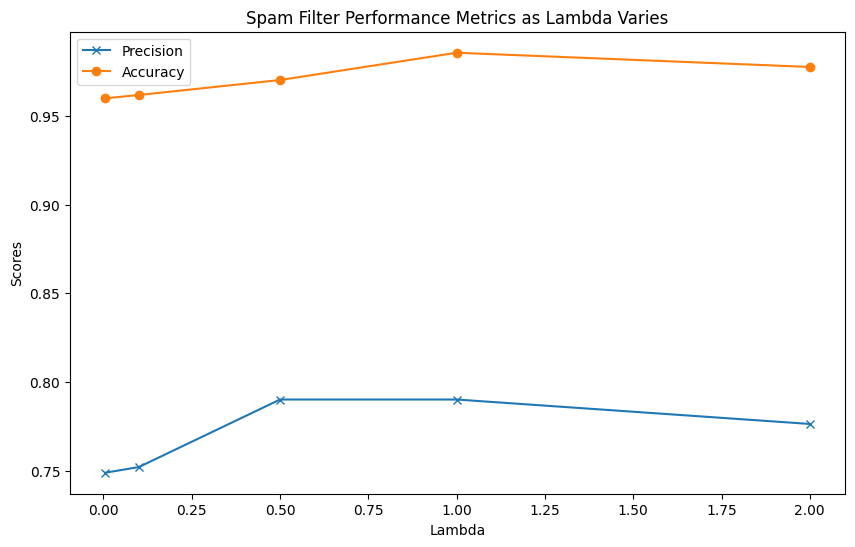

In [24]:
# Example lambda values
lambdas = [2, 1, 0.5, 0.1, 0.005]

# Corresponding accuracy and precision scores for each lambda value
# These are hypothetical values for demonstration purposes
precision_scores = [precision_l1, precision_l2, precision_l2, precision_l4, precision_l5]
recall_scores = [recall_l1, recall_l2, recall_l3, recall_l4, recall_l5]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(lambdas, precision_scores, label='Precision', marker='x')
plt.plot(lambdas, recall_scores, label='Accuracy', marker='o')

# Adding titles and labels
plt.title('Spam Filter Performance Metrics as Lambda Varies')
plt.xlabel('Lambda')
plt.ylabel('Scores')
plt.legend()

# Display the plot
plt.show()
